In [1]:
import os
import sys

current_working_directory = os.getcwd()
project_directory = os.path.dirname(os.path.dirname(current_working_directory))
utils_path = os.path.join(project_directory, 'utils')
plotting_path = os.path.join(project_directory, 'plotting_templates')
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [2]:
import jax
jax.config.update("jax_enable_x64", True) # Enable 64-bit double precision

# Imports
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utilities
from utils_DST import *
from utils_error import compute_2d_error
from utils_elliptic_dst_2d import *

In [3]:
plt.style.use(plotting_path + '/plot_style-Examples_3d.txt')
width = 4
height = width * 3 / 4

# Semilinear example


We will consider the problem 

\begin{aligned}
 -\nu \Delta u + bu+c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}



In [4]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

In [5]:
key = random.PRNGKey(647023)

c = 1.0
beta = 0.5

n_coef = 2**10
print("Number of coefficients: ", n_coef)

nu = 1e-1
b = jit(lambda x, y:1)#jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:] # make sure to exclude the points 0 and 1!
y_finest = jnp.linspace(lower,upper,n_coef +1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x_finest, y_finest)
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef) + 1

delta = .15
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))


decay = (jnp.arange(1,n_coef + 1)[None]**2 + jnp.arange(1,n_coef+1)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))


Number of coefficients:  1024


In [6]:
tau = jit(lambda x: c*jnp.sin(beta*2*jnp.pi*x))
tau_prime = jit(lambda x: c*jnp.cos(beta*2*jnp.pi*x)*beta*2*jnp.pi)

In [7]:
u_values = dst_2d(coef_u)
f_values = dst_2d(coef_laplacian) + vmap_b(x_finest, y_finest)*u_values + tau(u_values)

In [8]:
coef_f = compute_sine_coef_2d(f_values)
print(jnp.mean(jnp.abs(coef_u - compute_sine_coef_2d(u_values))))

1.2605963582107911e-19


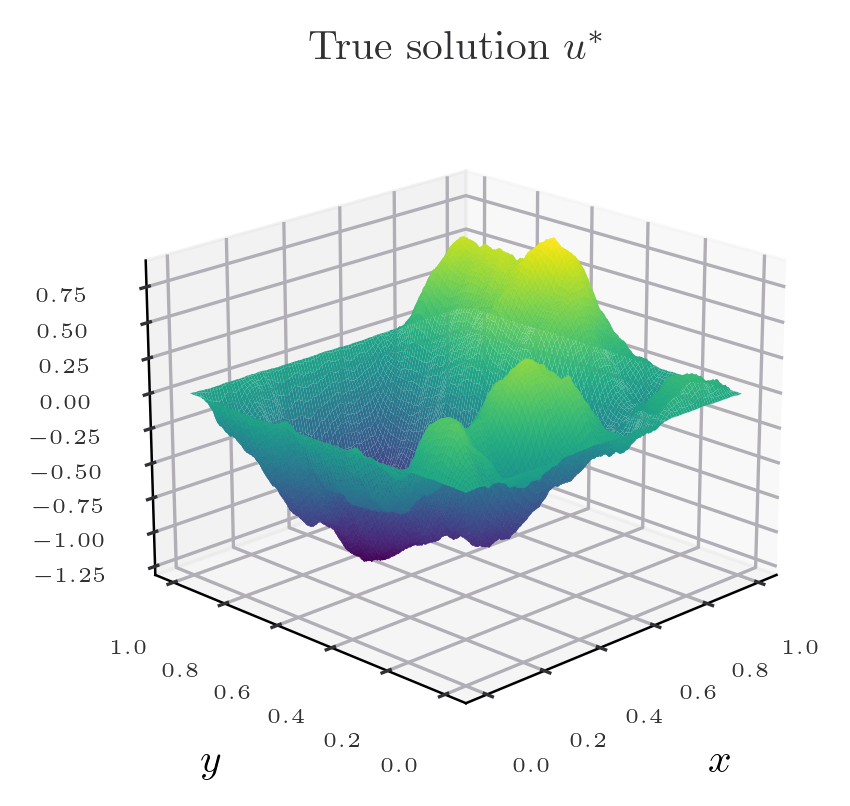

: 

In [10]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 10
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

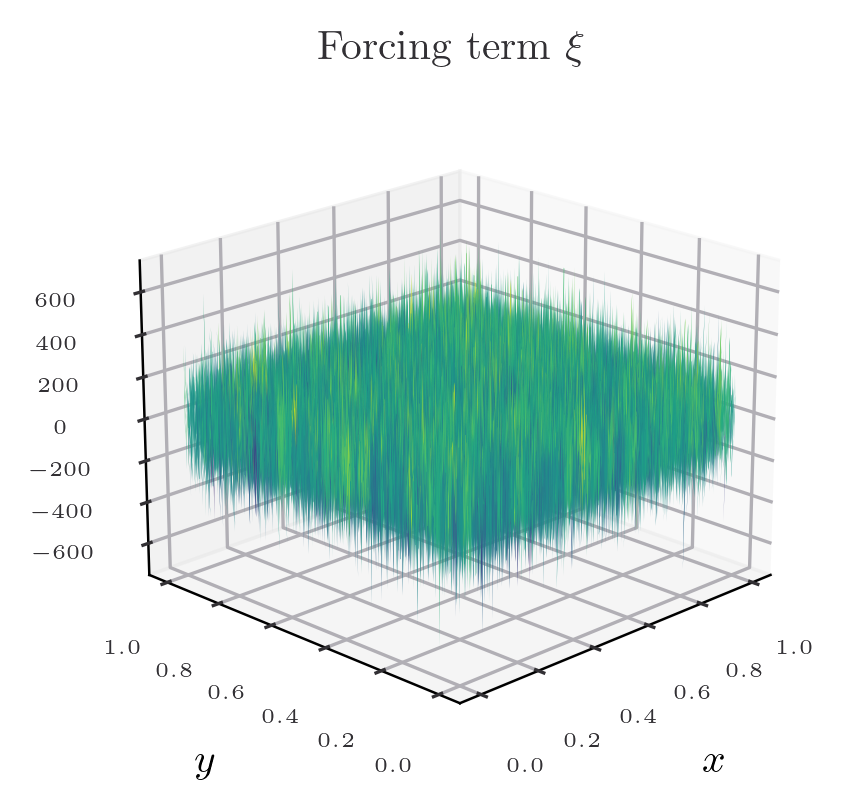

In [10]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

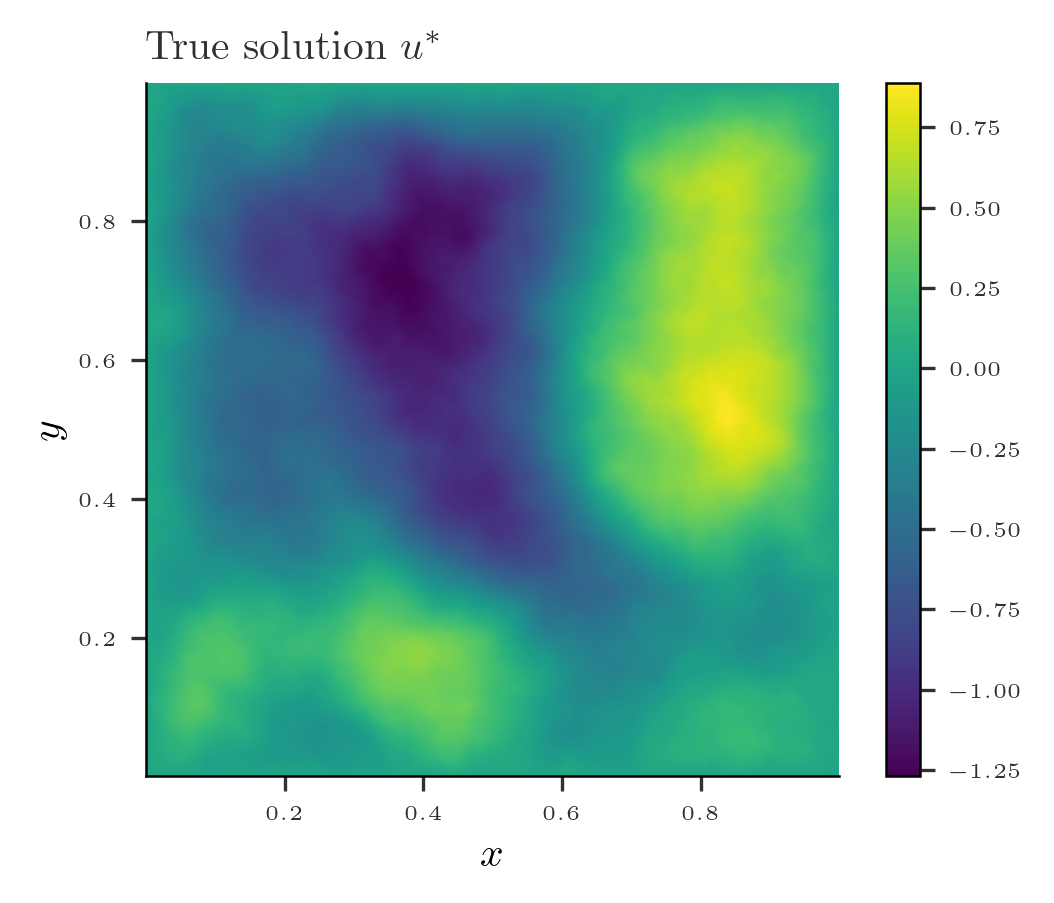

In [11]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

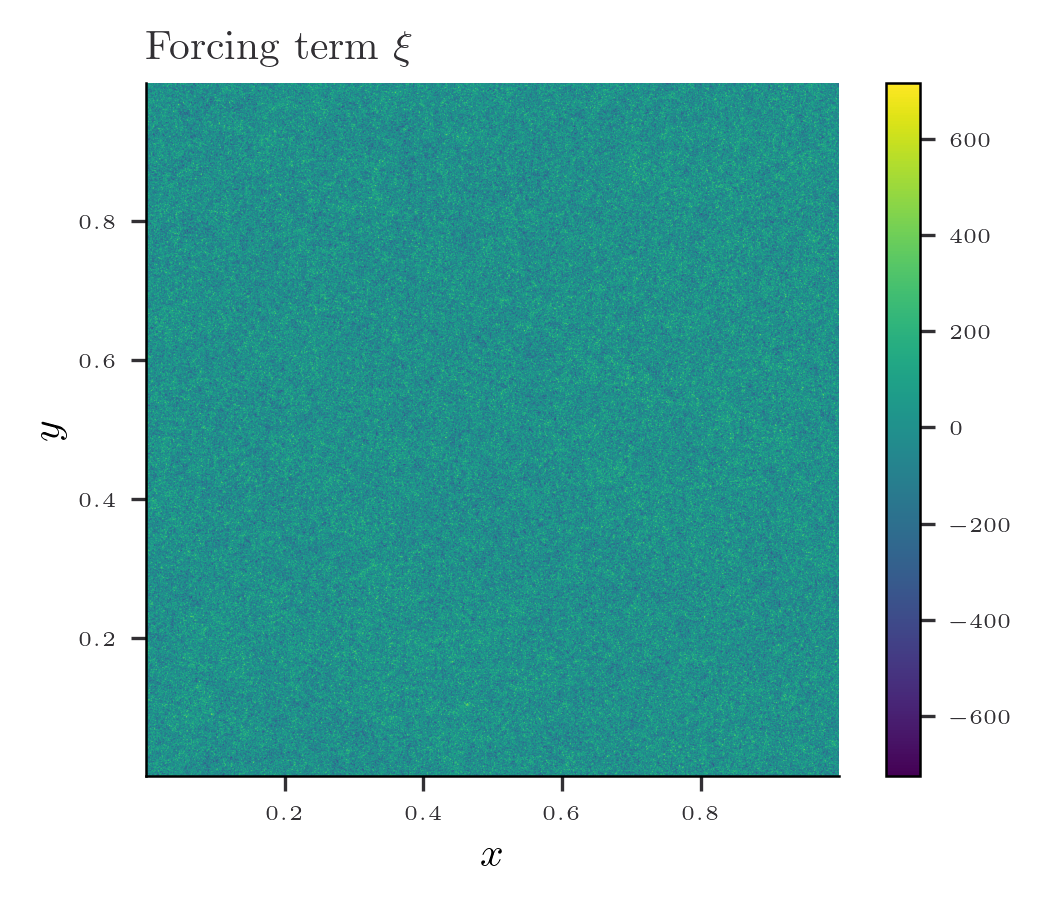

In [12]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

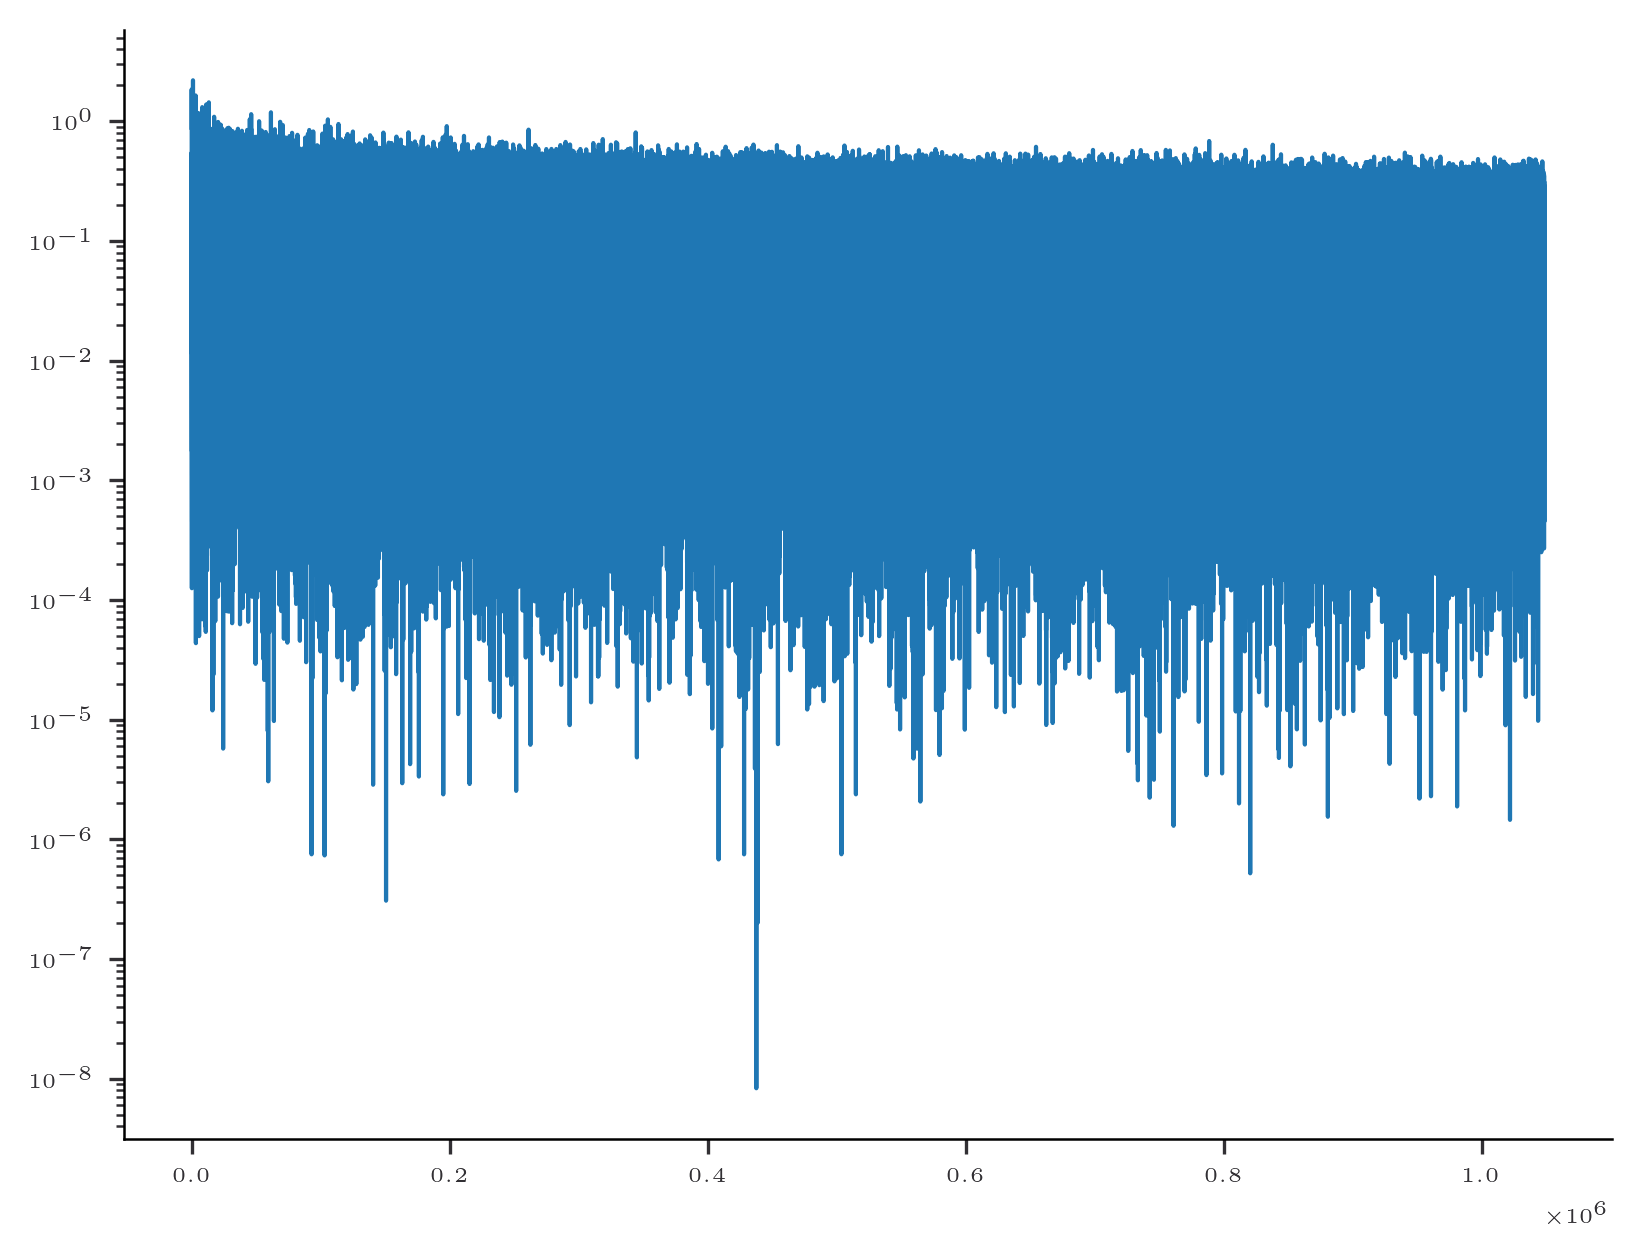

In [13]:
plt.plot(jnp.abs(coef_f.reshape(-1)), label = "f")
plt.yscale("log")
plt.show()

## Setting up the Gauss-Newton algorithm



With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Acutally we will have 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big)^\intercal \Theta^{-1}\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big) + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


At each iteration, we need to 

1. Compute $r_n : = [f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi]$
2. Build the new operator/kernel matrix using $\tau'(u_n)$.
3. Solve the system.


In [14]:
# 2d grid 
n_points = 2**6
print("Number of points {} along each axis ({} total measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:] # remember to not include the points 0 and 1
y = jnp.linspace(lower, upper, n_points + 1, endpoint=False)[1:]
X, Y = jnp.meshgrid(x, y)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)

Number of points 64 along each axis (4096 total measurements)


In [15]:
# Create a boundary
# Boundary points
boundary = jnp.hstack([jnp.zeros(1), x, jnp.zeros(1)])
n_boundary = boundary.shape[0]
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 66 (264 total)


In [16]:
n_eval = 2**8
x_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] 
y_eval = jnp.linspace(lower, upper, n_eval + 1, endpoint=False)[1:] 
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)

ratio = int(n_coef/n_eval)
u_eval = u_values[::ratio, ::ratio]

f_observed =  coef_f[:n_points,:n_points]
b_matrix = vmap_b(x, y)
b_matrix_linear = jnp.copy(b_matrix)
u_grid = u_values[::int(n_coef/n_points), ::int(n_coef/n_points)]

In [17]:
def Gauss_Newton(f, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay, reg, reg_bc):
    b_matrix = jnp.copy(b_matrix_linear)
    r_n = f
    n_points = f.shape[0]
    previous_error = jnp.inf
    
    for i in range(n_iter):
        print("Current iteration {}, current error {}".format(i+1, previous_error))

        # Build the matrix and sovle the system
        theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)
        alpha = solve(theta, boundary_condition, r_n, s_decay, reg_bc = reg_bc, reg = reg)

        # Evaluate on the grid
        pred_grid, pred = predict(alpha, x, y, x,y, boundary_points, length_scale, nu, b_matrix)

        # Evaluate the DST transform of  negative laplacian 
        K_laplacian_dst = jnp.vstack([theta_12_dst, theta_22_dst]).T
        L_dst = K_laplacian_dst@alpha

        # Compute the discrepancy with f
        error = jnp.linalg.norm(L_dst + compute_sine_coef_2d(tau(pred_grid)).reshape(n_points*n_points) - f.reshape(n_points*n_points))/jnp.linalg.norm(f.reshape(n_points*n_points))

        if jnp.abs(previous_error - error)/jnp.abs(error) < 1e-10:
            print("Converged at iteration {} with error {}".format(i+1, error))
            break
            
        previous_error = error


        if i < n_iter-1:
            # Compute the linearization
            linearization = tau_prime(pred_grid)*pred_grid - tau(pred_grid)
            # Project on the sine basis
            linearization = compute_sine_coef_2d(linearization)
            # Compute the residual
            r_n = f + linearization

            # Compute the new coefficent b
            b_matrix = b_matrix_linear + tau_prime(pred_grid)
    return alpha, b_matrix, r_n
    

In [18]:
length_scale = 1.25
s_decay =1.0

In [19]:
n_iter = 100
alpha, b_matrix, r =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay = s_decay, reg = 1e-9, reg_bc = 1e-12)

Current iteration 1, current error inf
Current iteration 2, current error 0.46500080524322385
Current iteration 3, current error 0.4677754627728102
Current iteration 4, current error 0.46743660217412825
Current iteration 5, current error 0.46746618413160373
Current iteration 6, current error 0.4674663662738648
Current iteration 7, current error 0.46746637077041203
Current iteration 8, current error 0.46746637100142546
Converged at iteration 8 with error 0.46746637096444005


In [20]:
pred_grid, pred= predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
e, e_rel = compute_2d_error(pred_grid, u_eval, x_eval, y_eval)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 1.19e-02. The relative L^2 error is 2.32e-02


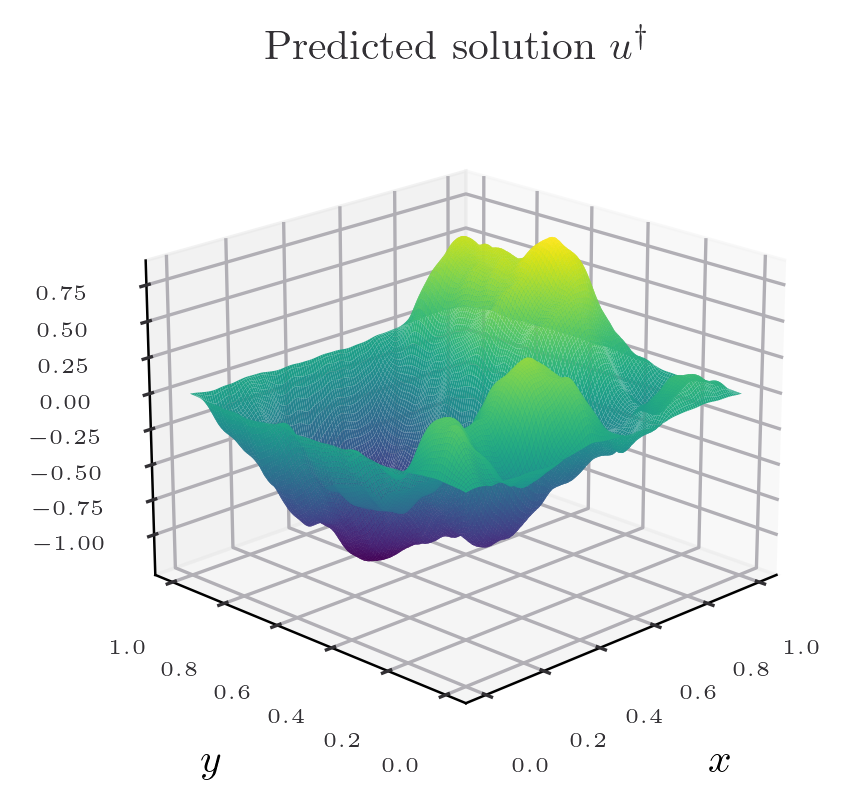

In [21]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 2
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

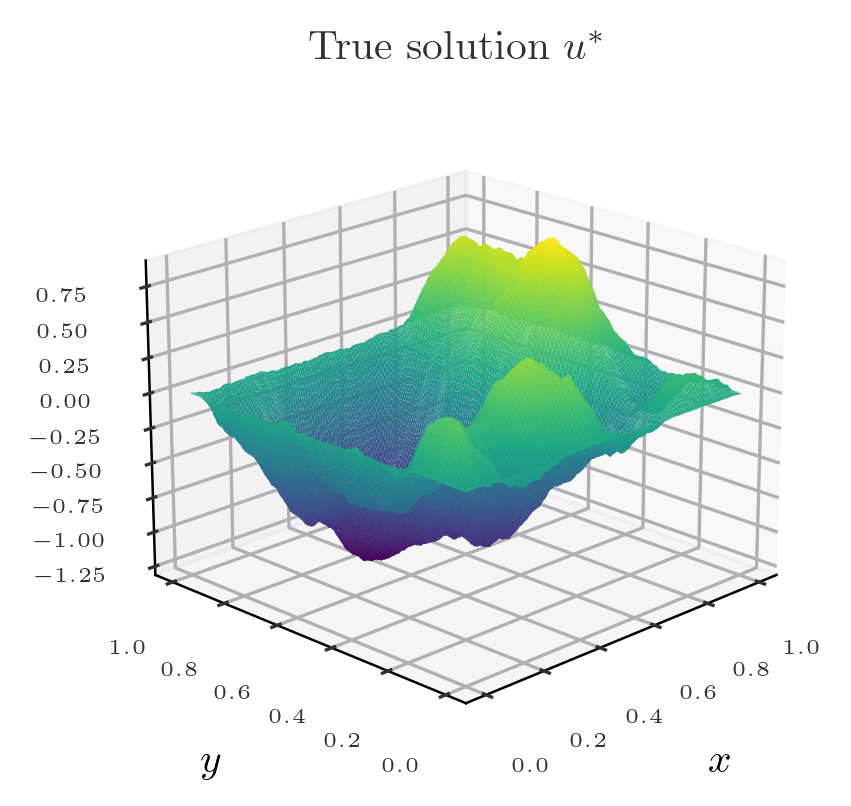

In [22]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

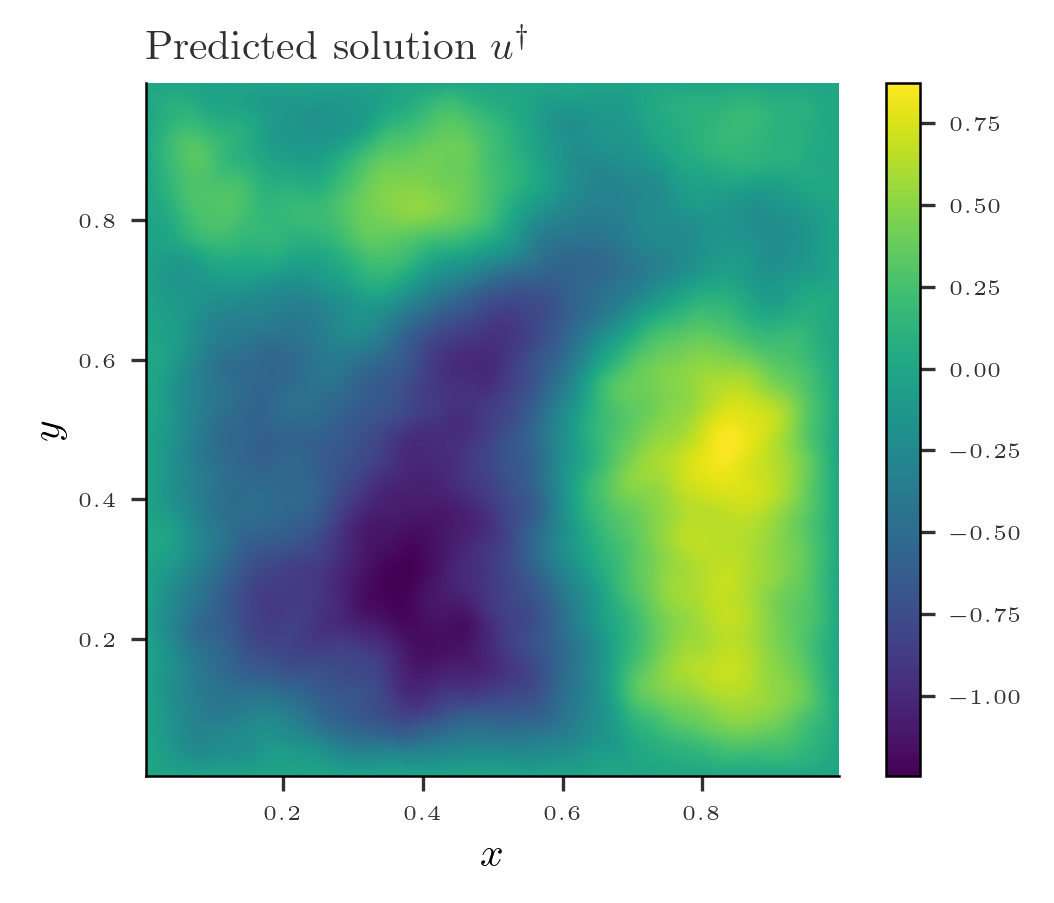

In [23]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

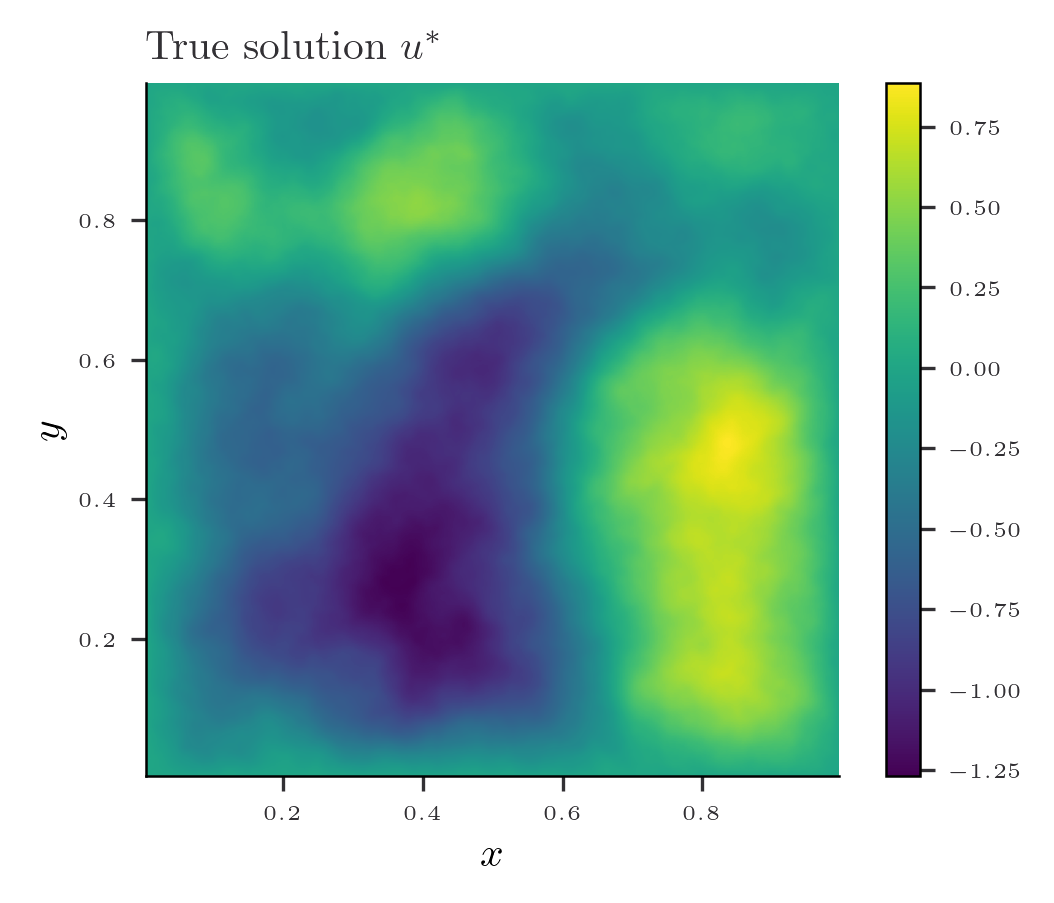

In [24]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_eval, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

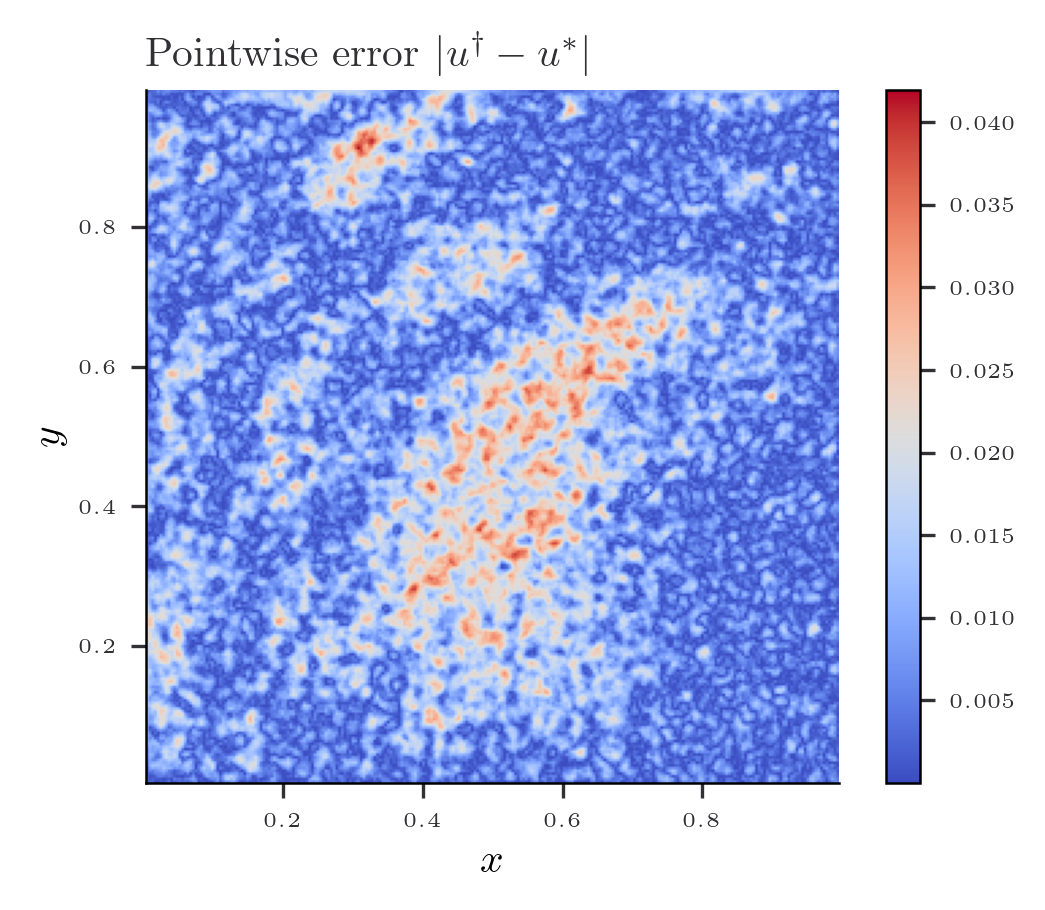

In [25]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_eval), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Pointwise version

In [29]:
ratio = int(n_coef/n_points)
f_observed =  coef_f[::ratio,::ratio]
b_matrix = vmap_b(x, y)
b_matrix_linear = jnp.copy(b_matrix)


In [32]:
def Gauss_Newton_pointwise(f, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay, reg, reg_bc):
    b_matrix = jnp.copy(b_matrix_linear)
    r_n = f
    n_points = f.shape[0]
    previous_error = jnp.inf
    
    for i in range(n_iter):
        print("Current iteration {}, current error {}".format(i+1, previous_error))

        # Build the matrix and sovle the system
        theta, theta_11, theta_12_dst, theta_22_dst = build_matrices_pointwise(boundary_points,x,y,length_scale, b_matrix, nu)
        alpha = solve_pointwise(theta, boundary_condition, r_n, s_decay, reg_bc = reg_bc, reg = reg)

        # Evaluate on the grid
        pred_grid, pred = predict_pointwise(alpha, x, y, x,y, boundary_points, length_scale, nu, b_matrix)

        # Evaluate the DST transform of  negative laplacian 
        K_laplacian_dst = jnp.vstack([theta_12_dst, theta_22_dst]).T
        L_dst = K_laplacian_dst@alpha

        # Compute the discrepancy with f
        error = jnp.linalg.norm(L_dst + tau(pred_grid).reshape(n_points*n_points) - f.reshape(n_points*n_points))/jnp.linalg.norm(f.reshape(n_points*n_points))

        if jnp.abs(previous_error - error)/jnp.abs(error) < 1e-10:
            print("Converged at iteration {} with error {}".format(i+1, error))
            break
        previous_error = error


        if i < n_iter-1:
            # Compute the linearization
            linearization = tau_prime(pred_grid)*pred_grid - tau(pred_grid)
           
            # Compute the residual
            r_n = f + linearization

            # Compute the new coefficent b
            b_matrix = b_matrix_linear + tau_prime(pred_grid)
    return alpha, b_matrix, r_n
    

In [33]:
n_iter = 200
alpha, b_matrix, r =  Gauss_Newton_pointwise(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, s_decay = None, reg = 1e-10, reg_bc = 1e-10)

Current iteration 1, current error inf
Current iteration 2, current error 0.02073802343351862
Current iteration 3, current error 0.01524491924285745
Current iteration 4, current error 0.015245032618459392
Current iteration 5, current error 0.015245032433188291
Current iteration 6, current error 0.015245032476701474
Current iteration 7, current error 0.015245032336504004
Current iteration 8, current error 0.015245032389902323
Current iteration 9, current error 0.015245032632365433
Current iteration 10, current error 0.015245032299338959
Current iteration 11, current error 0.015245032192921964
Current iteration 12, current error 0.015245032305365037
Current iteration 13, current error 0.01524503214494938
Current iteration 14, current error 0.01524503252000629
Current iteration 15, current error 0.015245032688276643
Current iteration 16, current error 0.015245032783324218
Current iteration 17, current error 0.015245032281099484
Current iteration 18, current error 0.015245032494778163
Curr

In [34]:
pred_grid, pred= predict_pointwise(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)
e, e_rel = compute_2d_error(pred_grid, u_eval, x_eval, y_eval)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))

The L^2 error is 5.13e-01. The relative L^2 error is 1.00e+00


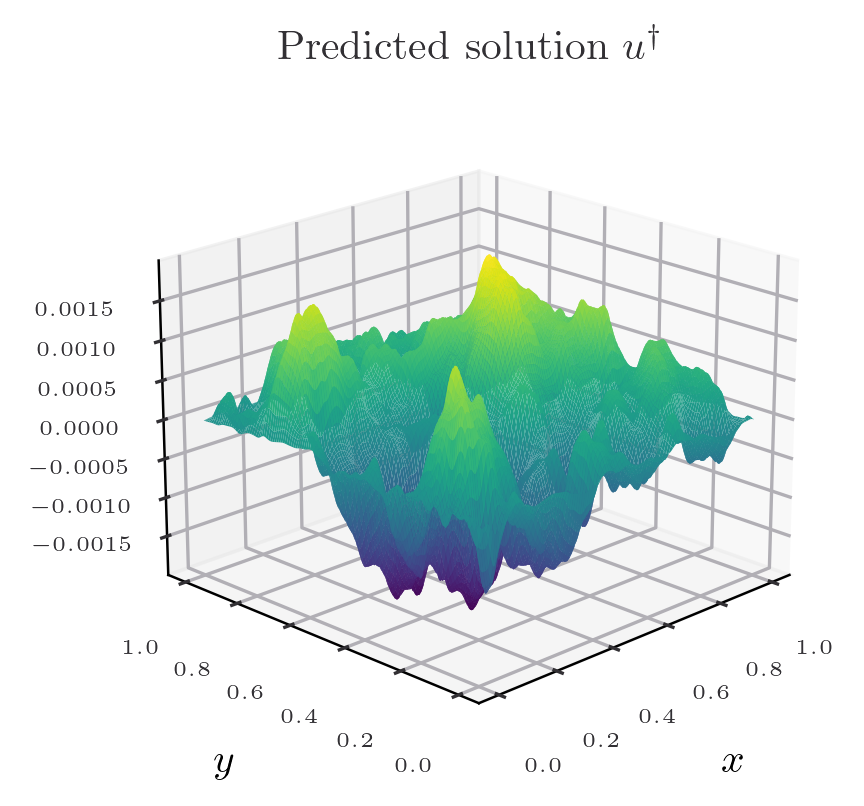

In [35]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, Y = jnp.meshgrid(x_eval, y_eval)
stride = 2
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

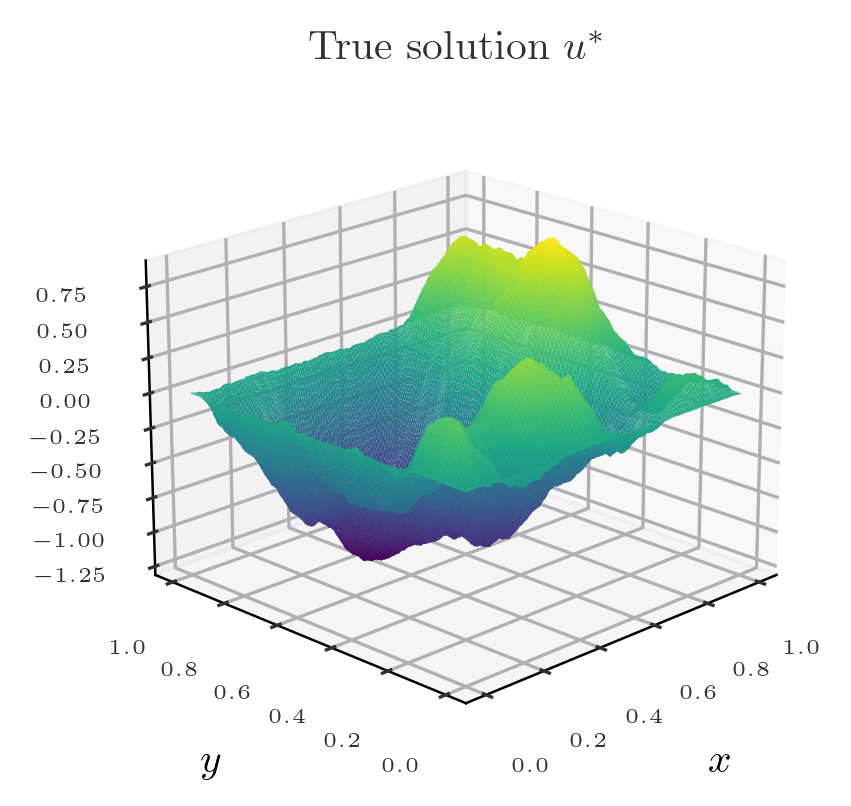

In [36]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

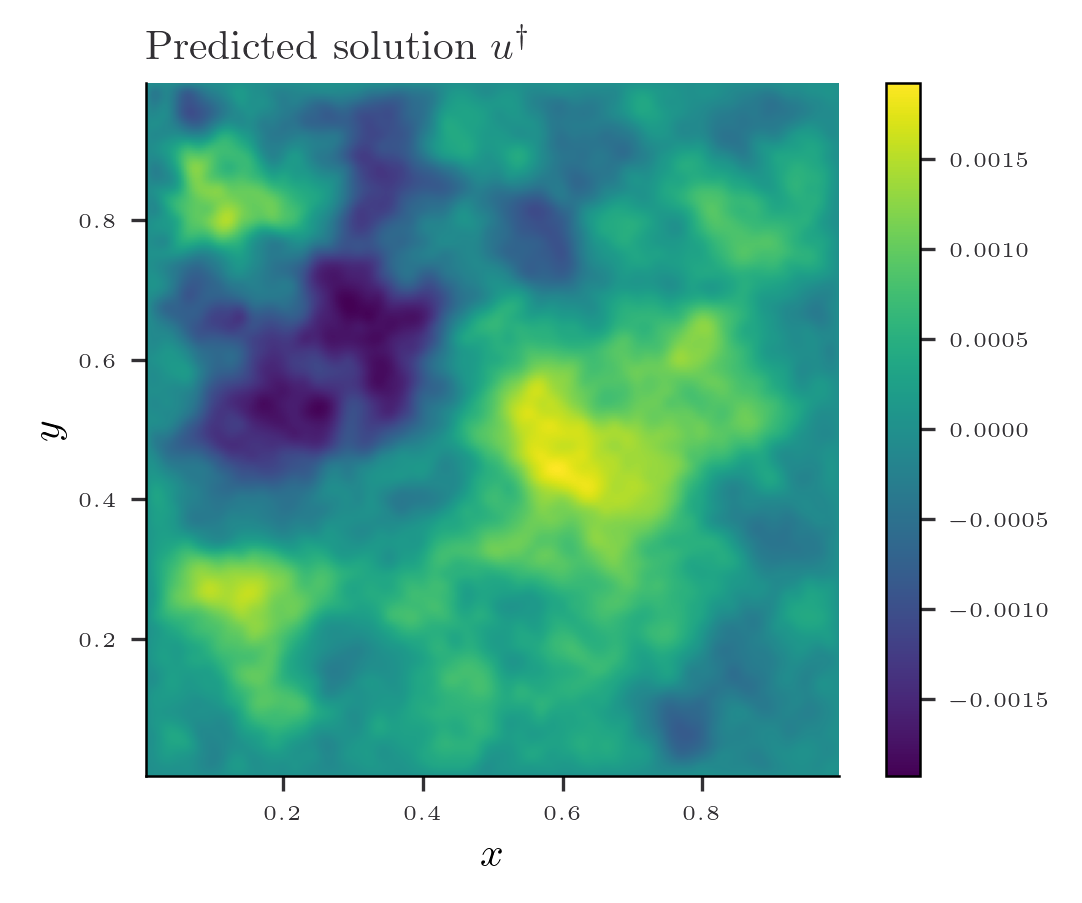

In [37]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

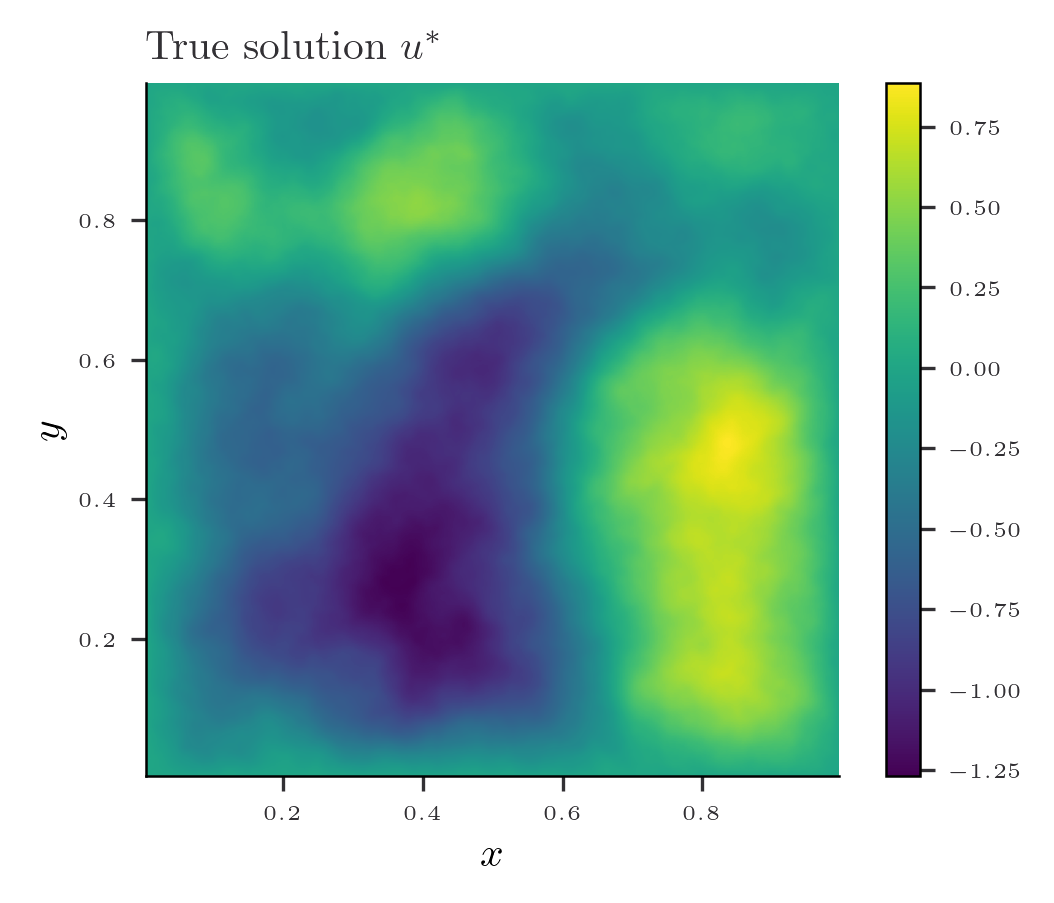

In [38]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_eval, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

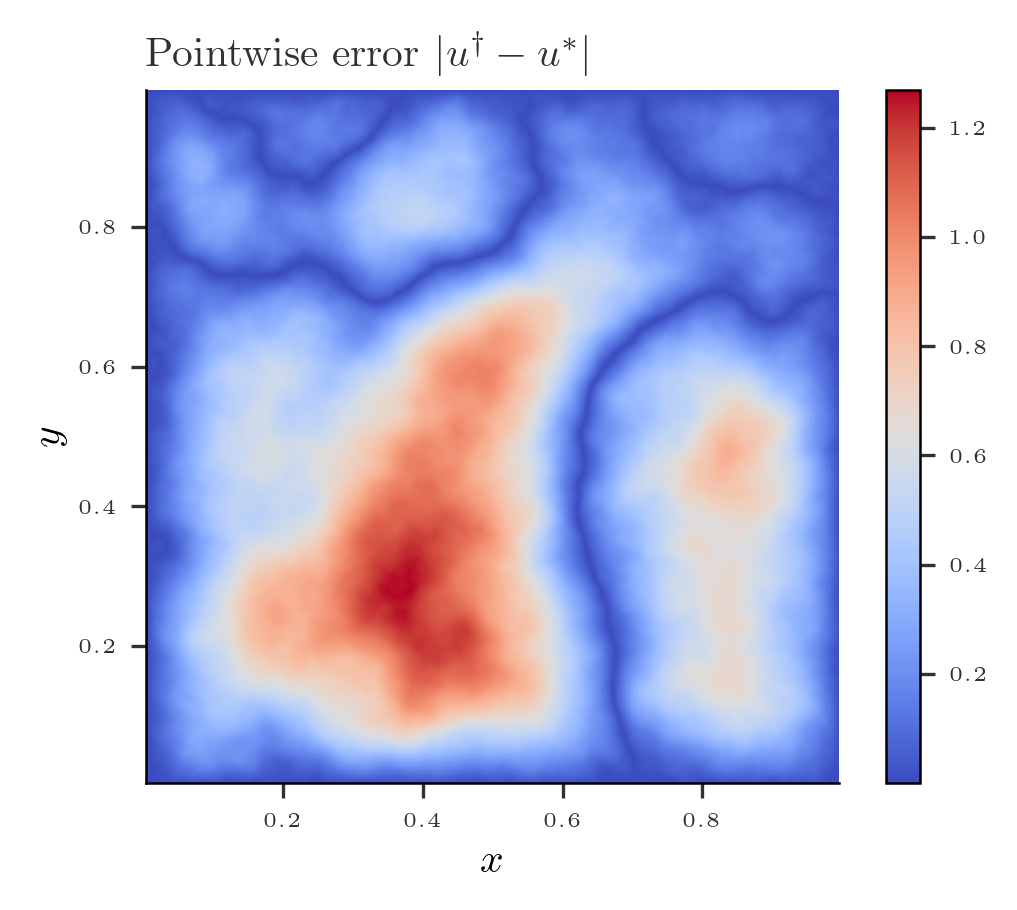

In [39]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_eval), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()